# Import Dependencies

In [35]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Load Dataset

In [38]:
# Load the clean dataset
data_path = "../dataset/clean_data.csv"
df = pd.read_csv(data_path)
df.head()

,Indicator Name,Year,Sex,Age Group,Age Category,Number,Percent of All Causes,Death Rate
0,All Causes,2020,All,[All],All Ages,109155.0,100.0,337.252065
1,All Causes,2020,All,[0],Infant,2367.0,100.0,444.185060
2,All Causes,2020,All,[1-4],Toddler,410.0,100.0,19.503136
3,All Causes,2020,All,[5-9],Child,294.0,100.0,11.722119
4,All Causes,2020,All,[10-14],Child,402.0,100.0,16.434815


# Death Count for All Causes (2000 to 2020)

In [41]:
# Filter dataset
filtered_df = df[
    (df['Indicator Name'] == 'All Causes') &
    (df['Sex'] == 'All') &
    (df['Age Category'] == 'All Ages')
]
filtered_df

,Indicator Name,Year,Sex,Age Group,Age Category,Number,Percent of All Causes,Death Rate
0,All Causes,2020,All,[All],All Ages,109155.0,100.0,337.252065
11140,All Causes,2019,All,[All],All Ages,109164.0,100.0,341.673746
22280,All Causes,2018,All,[All],All Ages,117387.0,100.0,372.325797
33420,All Causes,2017,All,[All],All Ages,97440.0,100.0,313.265099
44560,All Causes,2016,All,[All],All Ages,85637.0,100.0,279.087390
55700,All Causes,2015,All,[All],All Ages,80691.0,100.0,266.562391
66840,All Causes,2014,All,[All],All Ages,77365.0,100.0,251.933282
77980,All Causes,2013,All,[All],All Ages,74147.0,100.0,245.408832
89120,All Causes,2012,All,[All],All Ages,71848.0,100.0,243.469829
100260,All Causes,2011,All,[All],All Ages,70836.0,100.0,243.740666


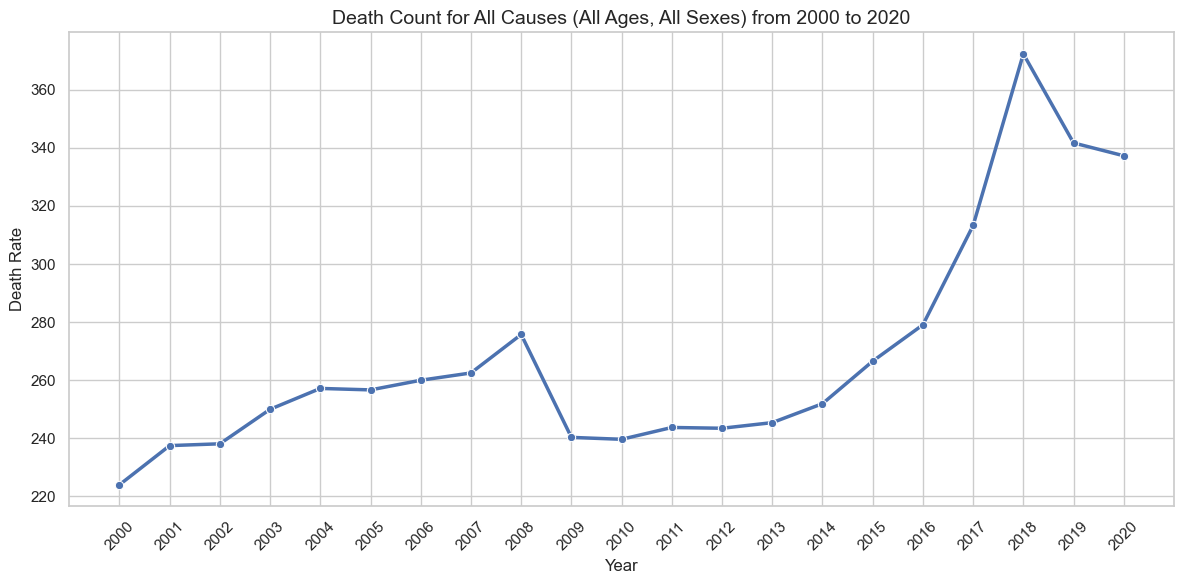

In [43]:
# Ensure the year is sorted and in integer format
filtered_df = filtered_df.sort_values(by='Year')
filtered_df['Year'] = filtered_df['Year'].astype(int)

# Set Seaborn style
sns.set(style="whitegrid")

# Create the plot
plt.figure(figsize=(12, 6))
sns.lineplot(data=filtered_df, x='Year', y='Death Rate', marker='o', linewidth=2.5)

# Customize ticks and labels
plt.title('Death Count for All Causes (All Ages, All Sexes) from 2000 to 2020', fontsize=14)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Death Rate', fontsize=12)

# Show one tick per year without decimals
plt.xticks(ticks=filtered_df['Year'], labels=filtered_df['Year'].astype(str), rotation=45)

# Remove y-axis decimals
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: int(x)))

# Final layout
plt.tight_layout()
plt.show()

# Top 5 Highest Death Count Causes of Death

In [46]:
# Filter dataset
filtered_df = df[df['Indicator Name'] != 'All Causes']

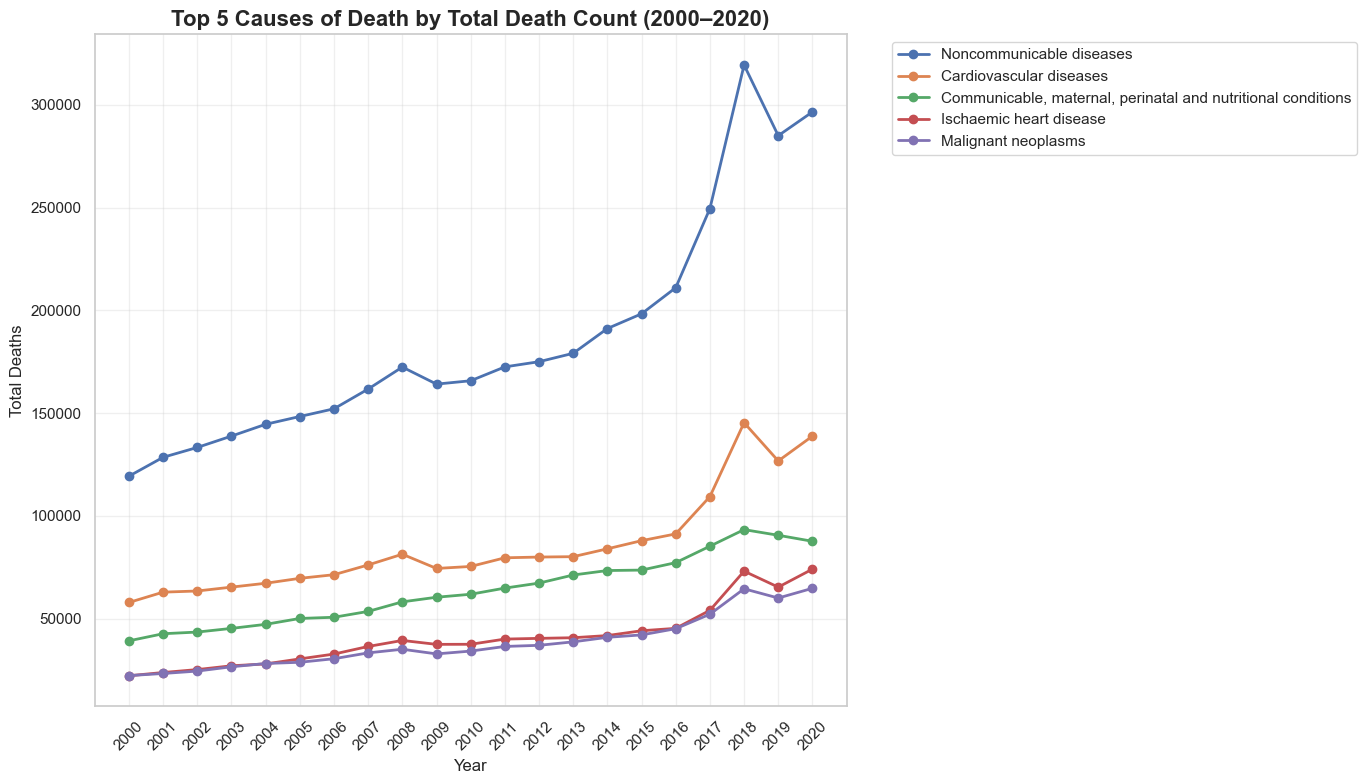

In [48]:
# 1. Identify overall top 5 causes by total deaths
cause_sums = filtered_df.groupby('Indicator Name')['Number'] \
                       .sum() \
                       .sort_values(ascending=False)
top5_causes = cause_sums.head(5).index.tolist()

# 2. Prepare temporal trends data
temporal_data = filtered_df[filtered_df['Indicator Name'].isin(top5_causes)].copy()
yearly_trends = (temporal_data
                 .groupby(['Year', 'Indicator Name'])['Number']
                 .sum()
                 .reset_index())
trends_pivot = yearly_trends.pivot(index='Year',
                                   columns='Indicator Name',
                                   values='Number')

# 3. Plot the trends
plt.figure(figsize=(14, 8))
for cause in top5_causes:
    if cause in trends_pivot.columns:
        plt.plot(trends_pivot.index,
                 trends_pivot[cause],
                 marker='o',
                 linewidth=2,
                 label=cause)

plt.title('Top 5 Causes of Death by Total Death Count (2000–2020)',
          fontsize=16,
          fontweight='bold')
plt.xlabel('Year', fontsize=12)
plt.ylabel('Total Deaths', fontsize=12)
plt.xticks(ticks=trends_pivot.index, rotation=45)  # <-- Show every year
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Distribution of Top 5 Causes of Death Across Genders

In [51]:
# Filter dataset
filtered_df = df[df['Indicator Name'] != 'All Causes']
filtered_df = filtered_df[filtered_df['Indicator Name'].isin(top5_causes)]
filtered_df

,Indicator Name,Year,Sex,Age Group,Age Category,Number,Percent of All Causes,Death Rate
20,"Communicable, maternal, perinatal and nutritio...",2020,All,[All],All Ages,21904.0,20.066877,67.675958
21,"Communicable, maternal, perinatal and nutritio...",2020,All,[0],Infant,1163.0,49.133925,218.245553
22,"Communicable, maternal, perinatal and nutritio...",2020,All,[1-4],Toddler,59.0,14.390244,2.806549
23,"Communicable, maternal, perinatal and nutritio...",2020,All,[5-9],Child,42.0,14.285714,1.674588
24,"Communicable, maternal, perinatal and nutritio...",2020,All,[10-14],Child,50.0,12.437811,2.044131
...,...,...,...,...,...,...,...,...
232595,Ischaemic heart disease,2000,Female,[65-69],Senior,338.0,16.003788,178.983711
232596,Ischaemic heart disease,2000,Female,[70-74],Senior,294.0,14.468504,217.059071
232597,Ischaemic heart disease,2000,Female,[75-79],Senior,245.0,14.244186,293.888322
232598,Ischaemic heart disease,2000,Female,[80-84],Elderly,185.0,13.951735,415.114661


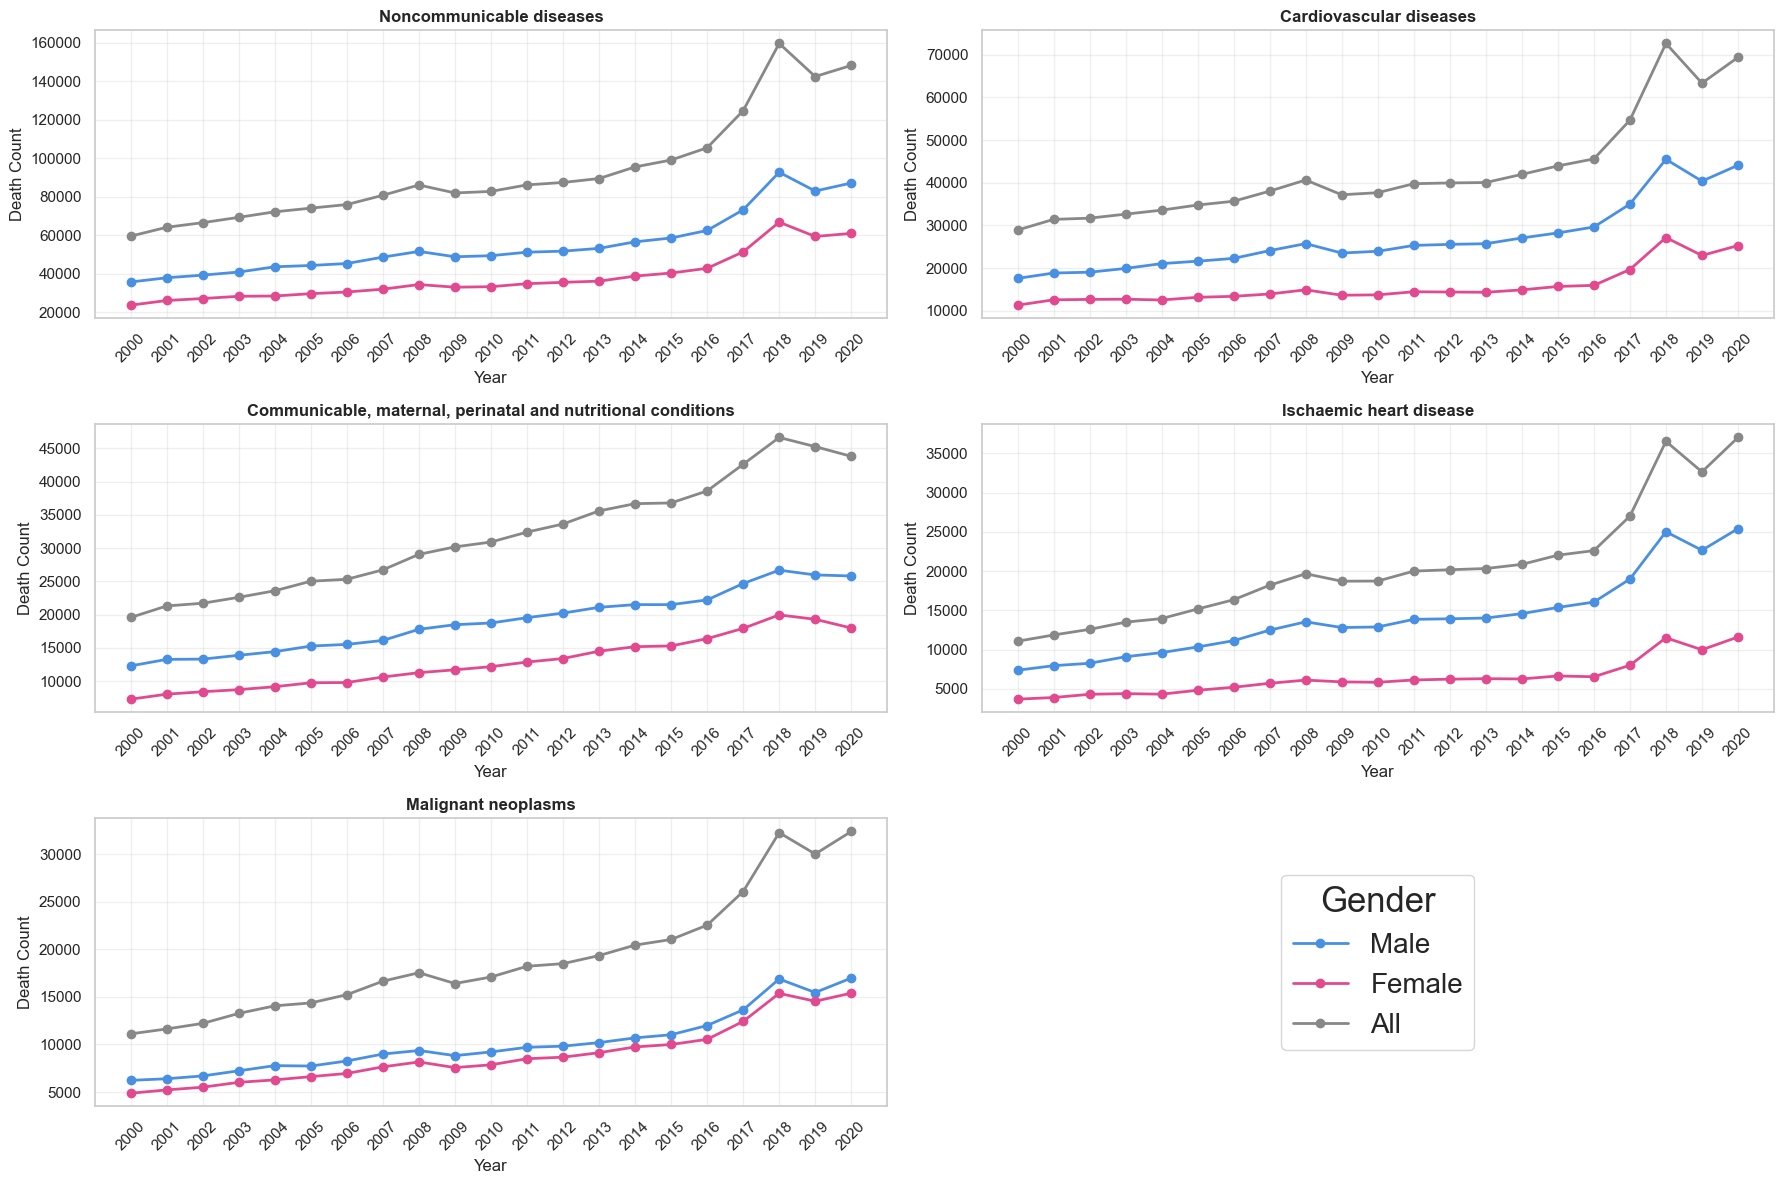

In [53]:
import matplotlib.pyplot as plt

# Define custom gender colors
gender_colors = {
    'Male': '#4A90E2',    # Blue
    'Female': '#E24A90',  # Pink
    'All': '#888888'      # Gray
}

# Set up subplots: 3 rows × 2 columns
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(18, 12))
axes = axes.flatten()

# Prepare to store legend handles and labels
legend_handles = []
legend_labels = []

# Plot each cause in its subplot (first 5)
for idx, cause in enumerate(top5_causes):
    ax = axes[idx]
    
    # Filter and group data for the current cause
    cause_data = df[df['Indicator Name'] == cause]
    trend = (cause_data.groupby(['Year', 'Sex'])['Number']
                        .sum()
                        .reset_index()
                        .pivot(index='Year', columns='Sex', values='Number'))

    for gender in ['Male', 'Female', 'All']:
        if gender in trend.columns:
            line, = ax.plot(
                trend.index,
                trend[gender],
                marker='o',
                linewidth=2,
                color=gender_colors[gender],
                label=gender
            )

            # Collect legend handles only once (e.g., first subplot only)
            if idx == 0:
                legend_handles.append(line)
                legend_labels.append(gender)

    ax.set_title(cause, fontsize=12, fontweight='bold')
    ax.set_xlabel('Year')
    ax.set_ylabel('Death Count')
    ax.grid(True, alpha=0.3)
    ax.set_xticks(trend.index)
    ax.tick_params(axis='x', rotation=45)

# Use 6th subplot for legend
legend_ax = axes[-1]
legend_ax.axis('off')

# Add shared legend with large font sizes
legend_ax.legend(
    handles=legend_handles,
    labels=legend_labels,
    title='Gender',
    loc='center',
    fontsize=20,
    title_fontsize=25,
    frameon=True
)

plt.tight_layout()
plt.show()


# Distribution of Top 5 Cause of Death Across Age Group

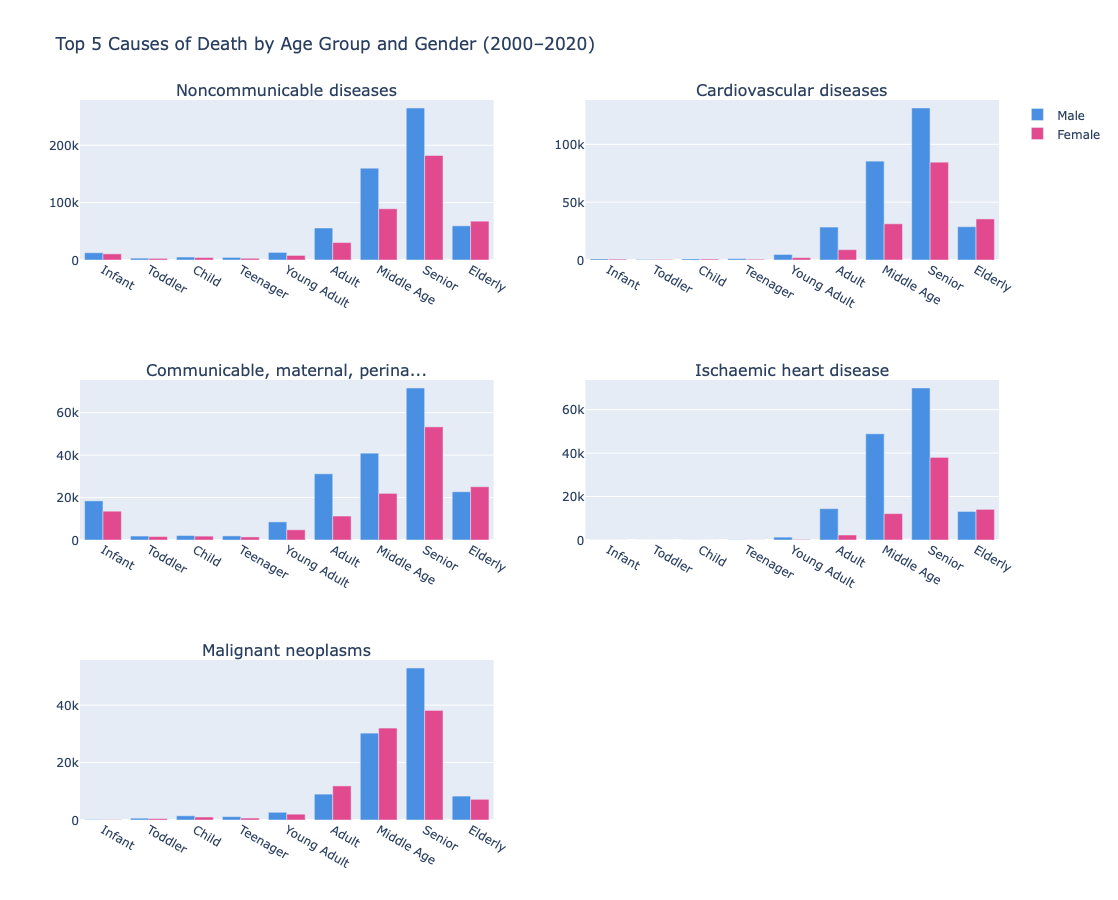

In [56]:
# Custom age order
age_order = [
    "Infant", "Toddler", "Child", "Teenager", "Young Adult",
    "Adult", "Middle Age", "Senior", "Elderly"
]

# 2. Identify overall top 5 causes
cause_sums = (
    filtered_df
    .groupby('Indicator Name')['Number']
    .sum()
    .sort_values(ascending=False)
)
top5_causes = cause_sums.head(5).index.tolist()

# 3. Build demographic breakdown for those causes, excluding 'All Ages'
demographic_analysis = (
    filtered_df[
        (filtered_df['Indicator Name'].isin(top5_causes)) &
        (filtered_df['Age Category'] != 'All Ages')
    ]
    .groupby(['Indicator Name', 'Sex', 'Age Category'])['Number']
    .sum()
    .reset_index()
)

# 4. Create interactive subplots
fig = make_subplots(
    rows=3, cols=2,
    subplot_titles=[(c[:30] + '...') if len(c) > 30 else c for c in top5_causes],
    specs=[
        [{"type": "bar"}, {"type": "bar"}],
        [{"type": "bar"}, {"type": "bar"}],
        [{"type": "bar"}, None]
    ]
)

colors_male = '#4A90E2'
colors_female = '#E24A90'

for idx, cause in enumerate(top5_causes):
    row = (idx // 2) + 1
    col = (idx % 2) + 1
    cause_data = demographic_analysis[demographic_analysis['Indicator Name'] == cause]
    
    male_data = (
        cause_data[cause_data['Sex'] == 'Male']
        .set_index('Age Category')
        .reindex(age_order)['Number']
        .fillna(0)
    )
    
    female_data = (
        cause_data[cause_data['Sex'] == 'Female']
        .set_index('Age Category')
        .reindex(age_order)['Number']
        .fillna(0)
    )
    
    if not male_data.empty:
        fig.add_trace(
            go.Bar(
                x=male_data.index,
                y=male_data.values,
                name='Male',
                marker_color=colors_male,
                showlegend=(idx == 0)
            ),
            row=row, col=col
        )
    if not female_data.empty:
        fig.add_trace(
            go.Bar(
                x=female_data.index,
                y=female_data.values,
                name='Female',
                marker_color=colors_female,
                showlegend=(idx == 0)
            ),
            row=row, col=col
        )

fig.update_layout(
    title_text="Top 5 Causes of Death by Age Group and Gender (2000–2020)",
    height=900,
    barmode='group'
)

fig.show()

# Top 5 Causes of Death for Each Age Category 

In [59]:
# Filter data
age_data = filtered_df[filtered_df['Age Category'] != 'All Ages'].copy()
specific_age_categories = sorted(age_data['Age Category'].unique())

# Dictionary to hold one DataFrame per age category
age_category_tables = {}

# Build top 5 tables for each age category
for age_category in specific_age_categories:
    age_subset = age_data[age_data['Age Category'] == age_category]
    top5_causes = (
        age_subset.groupby('Indicator Name')['Number']
        .sum()
        .sort_values(ascending=False)
        .head(5)
    )

    # Format deaths with commas
    formatted_deaths = [f"{int(n):,}" for n in top5_causes.values]

    # Build table as DataFrame
    df_top5 = pd.DataFrame({
        'Rank': range(1, len(top5_causes) + 1),
        'Cause of Death': top5_causes.index,
        'Total Deaths': formatted_deaths
    })

    # Save to dictionary
    age_category_tables[age_category] = df_top5

# Display all the tables
for category, table in age_category_tables.items():
    print(f"\n=== TOP 5 CAUSES FOR AGE CATEGORY: {category.upper()} ===")
    print(table.to_string(index=False))



=== TOP 5 CAUSES FOR AGE CATEGORY: ADULT ===
 Rank                                               Cause of Death Total Deaths
    1                                     Noncommunicable diseases      172,304
    2 Communicable, maternal, perinatal and nutritional conditions       84,916
    3                                      Cardiovascular diseases       74,762
    4                                          Malignant neoplasms       41,750
    5                                      Ischaemic heart disease       33,404

=== TOP 5 CAUSES FOR AGE CATEGORY: CHILD ===
 Rank                                               Cause of Death Total Deaths
    1                                     Noncommunicable diseases       18,606
    2 Communicable, maternal, perinatal and nutritional conditions        7,818
    3                                          Malignant neoplasms        4,988
    4                                      Cardiovascular diseases        3,266
    5                       